In [2]:
import os
os.getcwd()

'/workspace/hi/DropMix/Mixup_imagenet_exp'

In [3]:
from __future__ import division
# Codes are borrowed from https://github.com/vikasverma1077/manifold_mixup/tree/master/supervised

import os, sys, shutil, time, random
from collections import OrderedDict
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

sys.path.append('..')
sys.path.append('/workspace/hi/DropMix/Mixup_imagenet_exp/')
if sys.version_info[0] < 3:
    import cPickle as pickle
else:
    import _pickle as pickle
import argparse
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch.autograd import Variable
from load_data import load_data_subset
from logger import plotting, copy_script_to_folder, AverageMeter, RecorderMeter, time_string, convert_secs2time
import models
from multiprocessing import Pool
import matplotlib.pyplot as plt


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ngpu = 1
arch = 'wrn28_2'
batch_size = 128
dataset = 'cifar100'
stride = 1 # if cifar100
num_classes = 100
data_dir = '/'
labels_per_class = 500
valid_labels_per_class = 500
dropout = False

In [7]:
train_loader, valid_loader, _, test_loader, num_classes = load_data_subset(
    batch_size,
    2,
    dataset,
    data_dir,
    labels_per_class=labels_per_class,
    valid_labels_per_class=valid_labels_per_class,
    mixup_alpha=1.0)

exp = 'cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.5_box_transport_eps_0.8_size_-1_job_id__seed_0'
exp_root = os.path.join(os.getcwd(), 'ext_exp/CutMix')
resume_dir = os.path.join(exp_root, exp)
resume = os.path.join(resume_dir, 'model_best.pth.tar')

#     if exp.find('box') == -1 and exp.find('graph') == -1:
#     if True:
#     if exp.find('resnet56') != -1:

str_end = exp.lstrip('cifar100_arch_').find('_train')
# arch = exp.lstrip('cifar100_arch_')[:str_end]
arch = 'resnet56'

# create model
#         print("=> creating model '{}'".format(arch))
net = models.__dict__[arch](num_classes, dropout, stride).cuda()
net = torch.nn.DataParallel(net, device_ids=list(range(ngpu)))

if os.path.isfile(resume):
#             print("=> loading checkpoint '{}'".format(resume))
    checkpoint = torch.load(resume)
    recorder = checkpoint['recorder']
    start_epoch = checkpoint['epoch']
    net.load_state_dict(checkpoint['state_dict'])
    best_acc = recorder.max_accuracy(False)
    print(
        "=> loaded checkpoint '{}' accuracy={} (epoch {})".format(
            resume, best_acc, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume))

net.eval()

# val
correct_classes = torch.zeros(num_classes).cuda()
number_classes = torch.zeros(num_classes).cuda()

for i, (input, target) in enumerate(test_loader):
    target = target.cuda()
    input = input.cuda()

    output = net(input)
    output = output.data
    topk=(1,)

    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    for c, i in zip(correct.reshape(-1).float(), target):
        correct_classes[i] += c
        number_classes[i] += 1

np.save(os.path.join(resume_dir , 'correct_classes'), correct_classes.cpu().numpy().astype(int))
if number_classes.sum() != 10000:
    print("wrong number of classes")


Files already downloaded and verified
Files already downloaded and verified
=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/ext_exp/CutMix/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.5_box_transport_eps_0.8_size_-1_job_id__seed_0/model_best.pth.tar' accuracy=73.6500015258789 (epoch 243)


In [6]:
train_loader, valid_loader, _, test_loader, num_classes = load_data_subset(
    batch_size,
    2,
    dataset,
    data_dir,
    labels_per_class=labels_per_class,
    valid_labels_per_class=valid_labels_per_class,
    mixup_alpha=1.0)

from tqdm import tqdm

exp_root = os.path.join(os.getcwd(), 'experiments')
# exp_root = os.path.join(os.getcwd(), 'ext_exp/resnet56_mixup_108')
# exp_root = os.path.join(os.getcwd(), 'ext_exp/CutMix')
for exp in tqdm(sorted(os.listdir(exp_root))):
    resume_dir = os.path.join(exp_root, exp)
    resume = os.path.join(resume_dir, 'model_best.pth.tar')

    if exp.startswith('cifar100_arch_resnet56'):
#     if exp.find('box') == -1 and exp.find('graph') == -1:
#     if True:
#     if exp.find('resnet56') != -1:
#     if (not exp.startswith('cifar100_arch_resnet56')) and exp.startswith('cifar'):
        str_end = exp.lstrip('cifar100_arch_').find('_train')
        arch = exp.lstrip('cifar100_arch_')[:str_end]
        arch = 'resnet56'

        # create model
#         print("=> creating model '{}'".format(arch))
        net = models.__dict__[arch](num_classes, dropout, stride).cuda()
        net = torch.nn.DataParallel(net, device_ids=list(range(ngpu)))

        if os.path.isfile(resume):
#             print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            recorder = checkpoint['recorder']
            start_epoch = checkpoint['epoch']
            net.load_state_dict(checkpoint['state_dict'])
            best_acc = recorder.max_accuracy(False)
            print(
                "=> loaded checkpoint '{}' accuracy={} (epoch {})".format(
                    resume, best_acc, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

        net.eval()

        # val
        correct_classes = torch.zeros(num_classes).cuda()
        number_classes = torch.zeros(num_classes).cuda()

        for i, (input, target) in enumerate(test_loader):
            target = target.cuda()
            input = input.cuda()

            output = net(input)
            output = output.data
            topk=(1,)

            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            for c, i in zip(correct.reshape(-1).float(), target):
                correct_classes[i] += c
                number_classes[i] += 1

        np.save(os.path.join(resume_dir , 'correct_classes'), correct_classes.cpu().numpy().astype(int))
        if number_classes.sum() != 10000:
            print("wrong number of classes")


Files already downloaded and verified
Files already downloaded and verified


  0%|                                                                                     | 0/14 [00:00<?, ?it/s]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_box_transport_eps_0.8_size_-1_job_id__seed_0/model_best.pth.tar' accuracy=72.98999786376953 (epoch 242)


 29%|██████████████████████                                                       | 4/14 [00:08<00:21,  2.15s/it]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_box_transport_eps_0.8_size_-1_job_id__seed_1/model_best.pth.tar' accuracy=73.2300033569336 (epoch 227)


 36%|███████████████████████████▌                                                 | 5/14 [00:17<00:36,  4.05s/it]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_box_transport_eps_0.8_size_-1_job_id__seed_2/model_best.pth.tar' accuracy=72.66000366210938 (epoch 212)


 43%|█████████████████████████████████                                            | 6/14 [00:26<00:42,  5.33s/it]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_box_transport_eps_0.8_size_-1_job_id__seed_3/model_best.pth.tar' accuracy=73.13999938964844 (epoch 225)


 50%|██████████████████████████████████████▌                                      | 7/14 [00:35<00:43,  6.23s/it]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_box_transport_eps_0.8_size_-1_job_id__seed_4/model_best.pth.tar' accuracy=72.91000366210938 (epoch 208)


 57%|████████████████████████████████████████████                                 | 8/14 [00:43<00:41,  6.90s/it]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_transport_eps_0.8_size_-1_job_id__seed_0/model_best.pth.tar' accuracy=70.68000030517578 (epoch 210)


 64%|█████████████████████████████████████████████████▌                           | 9/14 [00:52<00:36,  7.35s/it]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_transport_eps_0.8_size_-1_job_id__seed_1/model_best.pth.tar' accuracy=70.76000213623047 (epoch 204)


 71%|██████████████████████████████████████████████████████▎                     | 10/14 [01:00<00:30,  7.71s/it]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_transport_eps_0.8_size_-1_job_id__seed_2/model_best.pth.tar' accuracy=71.05000305175781 (epoch 215)


 79%|███████████████████████████████████████████████████████████▋                | 11/14 [01:09<00:23,  7.99s/it]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_transport_eps_0.8_size_-1_job_id__seed_3/model_best.pth.tar' accuracy=71.52999877929688 (epoch 208)


 86%|█████████████████████████████████████████████████████████████████▏          | 12/14 [01:18<00:16,  8.15s/it]

=> loaded checkpoint '/workspace/hi/DropMix/Mixup_imagenet_exp/experiments/cifar100_arch_resnet56_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_0.3_transport_eps_0.8_size_-1_job_id__seed_4/model_best.pth.tar' accuracy=70.91000366210938 (epoch 230)


100%|████████████████████████████████████████████████████████████████████████████| 14/14 [01:26<00:00,  6.18s/it]


array([74.26 , 75.296, 75.89 , 76.152, 76.328, 76.722, 76.51 , 76.642,
       76.524, 75.94 , 75.442])

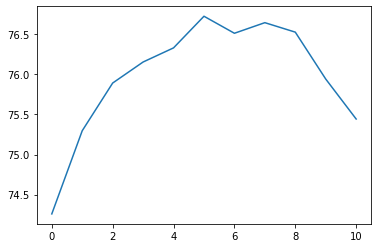

In [21]:
# cutmix analysis
number_seeds = 5
number_probs = 11
number_classes = 100

correct_classes_all = np.zeros([number_probs, number_seeds, num_classes])

exp_root = os.path.join(os.getcwd(), 'ext_exp/experiments')
exp_name = 'cifar100_arch_wrn28_2_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_1.0_box_transport_eps_0.8_size_-1_job_id__seed_4'
exp_name_1, exp_name_2 =exp_name.split('prob')
# for i in range(number_seeds):
#     correct_classes_all[0, i] = np.load(os.path.join(exp_root, 'cifar100_arch_wrn28_2_train_vanilla_eph_300_lr_0.1_transport_eps_0.8_size_-1_job_id__seed_{}'.format(i), 'correct_classes.npy'))
for j in range(11):
    for i in range(number_seeds):
        correct_classes_all[j, i] = np.load(os.path.join(exp_root, exp_name_1 + "prob_{}".format(j/10) +  exp_name_2[4:-1] + str(i), 'correct_classes.npy'))
#         print(exp_name_1 + "prob_{}".format(j/10) +  exp_name_2[4:-1] + str(i))

correct_classes_mean = np.mean(correct_classes_all, axis=1)
plt.plot(np.mean(correct_classes_mean, axis=1))
np.mean(correct_classes_mean, axis=1)

array([76.728, 78.38 , 78.732, 78.968, 79.27 , 79.526, 79.574, 79.588,
       79.35 , 79.136, 79.436])

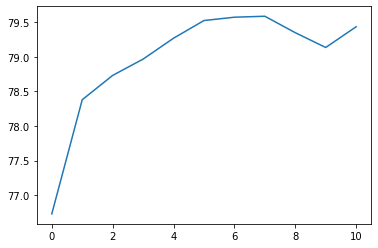

In [22]:
# cutmix analysis
number_seeds = 5
number_probs = 11
number_classes = 100

correct_classes_all = np.zeros([number_probs, number_seeds, num_classes])

exp_root = os.path.join(os.getcwd(), 'ext_exp/experiments')
exp_name = 'cifar100_arch_preactresnet18_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_1.0_box_transport_eps_0.8_size_-1_job_id__seed_4'
exp_name_1, exp_name_2 =exp_name.split('prob')
# for i in range(number_seeds):
#     correct_classes_all[0, i] = np.load(os.path.join(exp_root, 'cifar100_arch_wrn28_2_train_vanilla_eph_300_lr_0.1_transport_eps_0.8_size_-1_job_id__seed_{}'.format(i), 'correct_classes.npy'))
for j in range(11):
    for i in range(number_seeds):
        correct_classes_all[j, i] = np.load(os.path.join(exp_root, exp_name_1 + "prob_{}".format(j/10) +  exp_name_2[4:-1] + str(i), 'correct_classes.npy'))
#         print(exp_name_1 + "prob_{}".format(j/10) +  exp_name_2[4:-1] + str(i))

correct_classes_mean = np.mean(correct_classes_all, axis=1)
plt.plot(np.mean(correct_classes_mean, axis=1))
np.mean(correct_classes_mean, axis=1)

array([77.986, 79.592, 80.26 , 80.614, 81.02 , 81.14 , 81.184, 81.152,
       81.072, 81.064, 80.822])

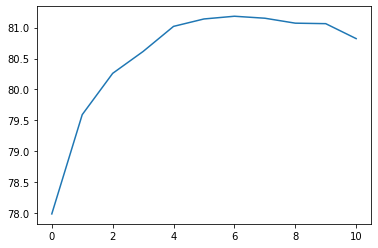

In [23]:
# cutmix analysis
number_seeds = 5
number_probs = 11
number_classes = 100

correct_classes_all = np.zeros([number_probs, number_seeds, num_classes])

exp_root = os.path.join(os.getcwd(), 'ext_exp/experiments')
exp_name = 'cifar100_arch_preactresnet34_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_1.0_box_transport_eps_0.8_size_-1_job_id__seed_4'
exp_name_1, exp_name_2 =exp_name.split('prob')
# for i in range(number_seeds):
#     correct_classes_all[0, i] = np.load(os.path.join(exp_root, 'cifar100_arch_wrn28_2_train_vanilla_eph_300_lr_0.1_transport_eps_0.8_size_-1_job_id__seed_{}'.format(i), 'correct_classes.npy'))
for j in range(11):
    for i in range(number_seeds):
        correct_classes_all[j, i] = np.load(os.path.join(exp_root, exp_name_1 + "prob_{}".format(j/10) +  exp_name_2[4:-1] + str(i), 'correct_classes.npy'))
#         print(exp_name_1 + "prob_{}".format(j/10) +  exp_name_2[4:-1] + str(i))

correct_classes_mean = np.mean(correct_classes_all, axis=1)
plt.plot(np.mean(correct_classes_mean, axis=1))
np.mean(correct_classes_mean, axis=1)

array([78.972, 80.732, 81.42 , 81.86 , 82.2  , 82.296, 82.32 , 82.3  ,
       81.778, 82.08 , 81.912])

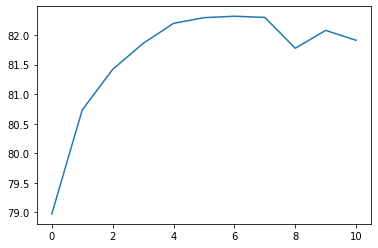

In [24]:
# cutmix analysis
number_seeds = 5
number_probs = 11
number_classes = 100

correct_classes_all = np.zeros([number_probs, number_seeds, num_classes])

exp_root = os.path.join(os.getcwd(), 'ext_exp/experiments')
exp_name = 'cifar100_arch_preactresnet50_train_mixup_eph_300_lr_0.2_m_alpha_1.0_m_prob_1.0_box_transport_eps_0.8_size_-1_job_id__seed_4'
exp_name_1, exp_name_2 =exp_name.split('prob')
# for i in range(number_seeds):
#     correct_classes_all[0, i] = np.load(os.path.join(exp_root, 'cifar100_arch_wrn28_2_train_vanilla_eph_300_lr_0.1_transport_eps_0.8_size_-1_job_id__seed_{}'.format(i), 'correct_classes.npy'))
for j in range(11):
    for i in range(number_seeds):
        correct_classes_all[j, i] = np.load(os.path.join(exp_root, exp_name_1 + "prob_{}".format(j/10) +  exp_name_2[4:-1] + str(i), 'correct_classes.npy'))
#         print(exp_name_1 + "prob_{}".format(j/10) +  exp_name_2[4:-1] + str(i))

correct_classes_mean = np.mean(correct_classes_all, axis=1)
plt.plot(np.mean(correct_classes_mean, axis=1))
np.mean(correct_classes_mean, axis=1)